# 29th Nov

# Baseline - Loss 

In [6]:
import pandas as pd
import numpy as np
import csv
from datetime import datetime
import matplotlib.pyplot as plt

# Preprocessing

In [7]:
def preprocess(df):
    df = df[['Date', 'Confirmed', 'Tested', 'First Dose Administered']].copy()
    # This contains the cumulative number of reported cases, tests done and cumulative number of vaccinations administered
    # Task 1 to find confirmed, vaccination and tests for each day    
    # calculate Rate of change 
    df["confirmed_perday"]=0.0
    df["confirmed_perday"][0]=df["Confirmed"][0].copy()
    df["vaccination_perday"]=0.0
    df["vaccination_perday"][0]=df["First Dose Administered"][0].copy()
    #df["rate_wanning"]=R_0/30.0
    df["tests_perday"]=0.0
    df["tests_perday"]=df["Tested"][0].copy()

    for i in range(1,len(df)):
        df["confirmed_perday"][i]=df["Confirmed"][i]-df["Confirmed"][i-1]
        df["tests_perday"][i]=df["Tested"][i]-df["Tested"][i-1]
        df["vaccination_perday"][i]=df["First Dose Administered"][i]-df["First Dose Administered"][i-1]    

    # Taking 7 day average of Confirmed and Tested
    df["Avg_7_Confirmed"]=0.0
    df["Avg_7_Tested"]=0.0
    df["Avg_7_Vaccination"]=0.0

    for i in range(0,7):
        df["Avg_7_Confirmed"][i]=sum(df["confirmed_perday"][0:i+1])/(i+1)
        df["Avg_7_Tested"][i]=sum(df["tests_perday"][0:i])/(i+1)
        df["Avg_7_Vaccination"][i]=sum(df["vaccination_perday"][0:i+1])/(i+1)   

    for i in range(6,len(df)):
        df["Avg_7_Confirmed"][i]=sum(df["confirmed_perday"][i-6:i+1])/7
        df["Avg_7_Tested"][i]=sum(df["tests_perday"][i-6:i+1])/7
        df["Avg_7_Vaccination"][i]=sum(df["vaccination_perday"][i-6:i+1])/7            

    return df

# Time Series Generation

In [8]:
# def weibull(x,l,k):
#     y = np.exp(-((x)/l)**k)
#     return y

def generateTimeSeries(S0, E0, I0, R0, N, V, ALPHA, BETA, GAMMA, EPS, ndays, avgTests):
    S = np.zeros((ndays))
    E = np.zeros((ndays))
    I = np.zeros((ndays))
    R = np.zeros((ndays))    

    # value initialisation

    S[0] = S0
    E[0] = E0
    I[0] = I0
    R[0] = R0
  
#----------------------#----------------------#----------------------#----------------------#----------------------#----------------------
    for day in range(ndays-1):
    #   Implement Immunity Wanning
        if flag==2:                 #Indicates Question 2
            S[day + 1] = S[day] - (BETA * S[day] * I[day])/N - EPS*V[day] +wanning[day]
            R[day + 1] = R[day] + GAMMA * I[day] + EPS*V[day]   -wanning[day]

        if flag==3:                 #Indicates Question 3(a)
            
            if day>(pd.to_datetime("2021-09-11")-pd.to_datetime("2021-03-16")).days:
                S[day + 1] = S[day] - (BETA * S[day] * I[day])/N - EPS*(V[day]-V[day-180]) + R[day-180]
                R[day + 1] = R[day] + GAMMA * I[day] + EPS*V[day] - R[day-180] -  EPS*V[day-180]
                
            elif day<=30:
                S[day + 1] = S[day] - (BETA * S[day] * I[day])/N - EPS*V[day] +wanning[day]
                R[day + 1] = R[day] + GAMMA * I[day] + EPS*V[day] -wanning[day]               
                wane=0.0
            else:
                S[day + 1] = S[day] - (BETA * S[day] * I[day])/N - EPS*V[day] 
                R[day + 1] = R[day] + GAMMA * I[day] + EPS*V[day]  
        if flag==4:
            S[day + 1] = S[day] - (BETA * S[day] * I[day])/N - EPS*V[day] #+ (EPS*V[day-180] + R[day-180])
            R[day + 1] = R[day] + GAMMA * I[day] + EPS*V[day] #- (R[day-180] +  EPS*V[day-180])
       
        
        E[day + 1] = E[day] * (1 - ALPHA) + (BETA * S[day] * I[day])/N 
        I[day + 1] = I[day] * (1 - GAMMA) + ALPHA * E[day]
#----------------------#----------------------#----------------------#----------------------#----------------------#----------------------       



    # return S, E, I, R,CIR

    # Calculating average of 7 days for all S,E,I,R data
    avgS=S
    avgE=E
    avgI=I
    avgR=R

    for day in range(0,7):
        avgS[day]=sum(S[0:day+1])/(day+1)
        avgE[day]=sum(E[0:day+1])/(day+1)
        avgI[day]=sum(I[0:day+1])/(day+1)
        avgR[day]=sum(R[0:day+1])/(day+1)
    
    for day in range(6,len(S)):
        avgS[day]=sum(S[day-6:day+1])/7
        avgE[day]=sum(E[day-6:day+1])/7
        avgI[day]=sum(I[day-6:day+1])/7
        avgR[day]=sum(R[day-6:day+1])/7
    return avgS,avgE,avgI,avgR

# Loss Function

In [9]:
def loss(paras):
    BETA,S0,E0,I0,R0,CIR0=paras[0],paras[1],paras[2],paras[3],paras[4],paras[5]
    #Model Generated Results
    genS, genE, genI, genR = generateTimeSeries(S0, E0, I0, R0, N, V, ALPHA, BETA, GAMMA, EPS, ndays, avgTests)

    #Generating CIR values
    genCIR = np.zeros((ndays))
    genCIR[0]=CIR0
    for day in range(1,ndays):
        genCIR[day]=CIR0*(avgTests[0]/avgTests[day])

    #Loss
    ModelGenetated = np.log(ALPHA*genE.T/genCIR + 1)                                   # Model Generated Data
    GT=np.log(df_reported["Avg_7_Confirmed"].to_numpy()+1)  
    loss_value = np.linalg.norm(ModelGenetated-GT)**2/ndays
    return loss_value

# Caliberation for Question 2

In [10]:
def caliberation(parameters):
    loss_value=loss(parameters)
    perturbations = [0.01, 1, 1, 1, 1, 0.1]
    j=1
    while loss_value > 0.01:    
        # updating one parameter at a time
        for index in range(len(parameters)):
            perturbed_pars1=parameters.copy()
            perturbed_pars2=parameters.copy()    
            
            #Checking on both sides of the perturbation value
            perturbed_pars1[index] = perturbed_pars1[index] + perturbations[index]
            perturbed_loss1 = loss(perturbed_pars1)

            perturbed_pars2[index] = perturbed_pars2[index] - perturbations[index]
            perturbed_loss2 = loss(perturbed_pars2)

            if (perturbed_loss1<perturbed_loss2):
                loss_new=perturbed_loss1
            else:
                loss_new=perturbed_loss2
            parameters[index] = parameters[index] - 1 / j * (loss_new - loss_value)
            if loss_new<=0.01:
                return loss_new,parameters

        loss_value = loss(parameters)
        if (j%100)==0:
            print("loss = ",loss_value)
        j += 1
        if j==100000:
            return loss_value,parameters

    return loss_value,parameters

# Main Function Question 1 and 2

In [ ]:
df = pd.read_csv('./COVID19_data.csv')

#Initialization
ALPHA=1/5.8
GAMMA=1/5
EPS=0.66
N=70000000

# Defining Initial Values for Parameters
# Percentages are defined based on calculated guess from the condition on that date

BETA=0.449722551
S0=48999999.97139864
E0=76999.9180
I0=76999.9182
R0=20852999.9
CIR0=12.8716990

# Ground Truth results
df_preprocessed = preprocess(df)
df_reported=df_preprocessed[(df_preprocessed["Date"]<="2021-04-26") & (df_preprocessed["Date"]>="2021-03-16")].copy().reset_index()

#Modifying daily vaccinations to include vaccinations for dates not provided
V=np.array(df_reported["Avg_7_Vaccination"])
list_vacc=np.ones((365))*200000
V=list(V)+list(list_vacc)
np.array(V)

avgTests=np.array(df_reported["Avg_7_Tested"])
ndays=(pd.to_datetime("2021-04-26")-pd.to_datetime("2021-03-16")).days+1

# Question 2
wanning=np.zeros((ndays))
for day in range(0,(pd.to_datetime("2021-04-15")-pd.to_datetime("2021-03-16")).days+1):
    wanning[day]=R0/30
parameters=[BETA,S0,E0,I0,R0,CIR0]
flag=2      #To denote question 2 is on
loss_value,parameters=caliberation(parameters)
print("-----------------Results--------------\n")
print("Question 2 Parameters Obtained\n", parameters)
print("Question 2 Loss Obtained\n", loss_value)

# Question 3(a)

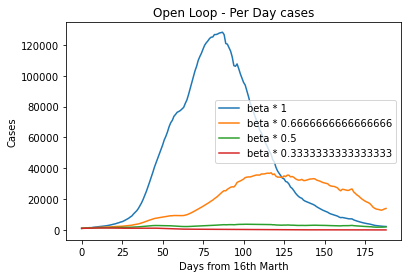

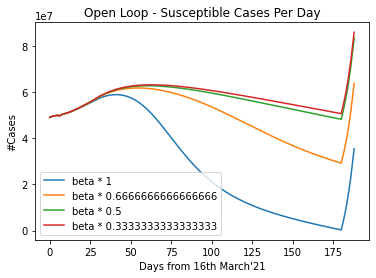

In [64]:
# Question 3 (a)

# Predictions from 27th Apr'21 till 31st Dec'21
ndays = (pd.to_datetime("2021-09-20")-pd.to_datetime("2021-03-16")).days+1
Duration_Part1 = (pd.to_datetime("2021-09-11")-pd.to_datetime("2021-03-16")).days+1


#Processing Tests - Keeping Avg number of tests done on 19th Sept as the Avg tests from 20th Sept to 31st Dec
avgTests_16Mar_19Sept = np.array(df_preprocessed[df_preprocessed["Date"]>="2021-03-16"]["Avg_7_Tested"])
lenTestDays = len(avgTests_16Mar_19Sept)
avgTests_19Sept_31Dec = np.ones(ndays-lenTestDays)*avgTests_16Mar_19Sept[lenTestDays-1]
avgTests = np.array(list(avgTests_16Mar_19Sept)+list(avgTests_19Sept_31Dec)) #Mergind both the lists; one contains avg tests till 19th Sept'21; other contains avg tests from 20th Sept'21 till 31st Dec'21

BETA,S0,E0,I0,R0,CIR0=parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5] #These valeus we have opbtained from question 2

#Plotting
flag=3 #To indicate question 3a

#Vaccinations
V=np.array(df_reported["Avg_7_Vaccination"])
list_vacc=np.ones((365))*200000
V=list(V)+list(list_vacc)
V=np.array(V)



# Different CASES with Beta - Plot of Daily Cases
factors=[1,2/3,1/2,1/3]
for factor in factors:
    # Generated per day cases
    genS, genE, genI, genR = generateTimeSeries(S0, E0, I0, R0, N, V, ALPHA, BETA*factor, GAMMA, EPS, ndays, avgTests)
    # Generate CIR values
    genCIR = np.zeros((ndays))
    genCIR[0]=CIR0
    for day in range(1,ndays):
        genCIR[day]=CIR0*(avgTests[0]/avgTests[day])
    dailyCases = np.array(ALPHA*genE.T/genCIR)
    plt.plot(dailyCases, label='beta * ' + str(factor))
    plt.legend()
    plt.title("Open Loop - Per Day cases")
    plt.xlabel("Days from 16th Marth")
    plt.ylabel("Cases")
plt.show()


plt.clf()
# Different CASES with Beta - Plot of Daily Susceptible Cases
factors=[1,2/3,1/2,1/3]
for factor in factors:
    # Generated per day cases
    genS, genE, genI, genR  = generateTimeSeries(S0, E0, I0, R0, N, V, ALPHA, BETA*factor, GAMMA, EPS, ndays, avgTests)
    plt.plot(genS, label='beta * ' + str(factor))
    plt.legend()
    plt.title("Open Loop - Susceptible Cases Per Day")
    plt.xlabel("Days from 16th March'21")
    plt.ylabel("#Cases")
plt.show()




In [55]:
# def weibull(x,l,k):
#     y = np.exp(-((x)/l)**k)
#     return y

def Question_3b_TimeSeries(S0, E0, I0, R0, N, V, ALPHA, BETA, GAMMA, EPS, ndays, avgTests):
    S = np.zeros((ndays))
    E = np.zeros((ndays))
    I = np.zeros((ndays))
    R = np.zeros((ndays))    
    avgS=S.copy()
    avgE=E.copy()
    avgI=I.copy()
    avgR=R.copy()

    # value initialisation

    S[0] = S0
    E[0] = E0
    I[0] = I0
    R[0] = R0
    factor=1
    day=0
    while(day<ndays-1):        
        BETA_New=factor*BETA
        if day>(pd.to_datetime("2021-09-11")-pd.to_datetime("2021-03-16")).days:
            S[day + 1] = S[day] - (BETA_New * S[day] * I[day])/N - EPS*(V[day]-V[day-180]) + R[day-180]
            R[day + 1] = R[day] + GAMMA * I[day] + EPS*V[day] - R[day-180] -  EPS*V[day-180]
            
        elif day<=30:
            S[day + 1] = S[day] - (BETA_New * S[day] * I[day])/N - EPS*V[day] 
            R[day + 1] = R[day] + GAMMA * I[day] + EPS*V[day]                
            wane=0.0
        else:
            S[day + 1] = S[day] - (BETA_New * S[day] * I[day])/N - EPS*V[day] 
            R[day + 1] = R[day] + GAMMA * I[day] + EPS*V[day]  
                
        E[day + 1] = E[day] * (1 - ALPHA) + (BETA_New * S[day] * I[day])/N 
        I[day + 1] = I[day] * (1 - GAMMA) + ALPHA * E[day]
        #print(day)
        day+=1
        
        if (day%7)==0:
            CIR_generated=CIR0*(avgTests[0]/avgTests[day])
            lastWeekAvg=sum(E[day-6:day+1])/7
            if (lastWeekAvg/CIR_generated)*ALPHA < 10000:
                factor=1
            elif (lastWeekAvg/CIR_generated)*ALPHA< 25000:
                factor=2/3
            elif (lastWeekAvg/CIR_generated)*ALPHA< 100000:
                factor=1/2
            else:
                factor=1/3

    # return S, E, I, R,CIR

    # Calculating average of 7 days for all S,E,I,R data
    avgS=S
    avgE=E
    avgI=I
    avgR=R

    for day in range(0,7):
        avgS[day]=sum(S[0:day+1])/(day+1)
        avgE[day]=sum(E[0:day+1])/(day+1)
        avgI[day]=sum(I[0:day+1])/(day+1)
        avgR[day]=sum(R[0:day+1])/(day+1)
    
    for day in range(6,len(S)):
        avgS[day]=sum(S[day-6:day+1])/7
        avgE[day]=sum(E[day-6:day+1])/7
        avgI[day]=sum(I[day-6:day+1])/7
        avgR[day]=sum(R[day-6:day+1])/7

    return avgS,avgE,avgI,avgR

# Question 3(b)

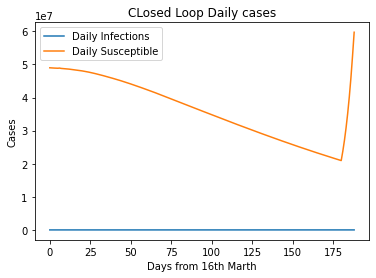

In [57]:
# Question 3 (b)
ndays = (pd.to_datetime("2021-09-20")-pd.to_datetime("2021-03-16")).days+1

genS, genE, genI, genR = Question_3b_TimeSeries(S0, E0, I0, R0, N, V, ALPHA, BETA, GAMMA, EPS, ndays, avgTests)
genCIR = np.zeros((ndays))
genCIR[0]=CIR0
for day in range(1,ndays):
    genCIR[day]=CIR0*(avgTests[0]/avgTests[day])
dailyCases = np.array(ALPHA*genE.T/genCIR)
plt.plot(dailyCases, label="Daily Infections")
plt.plot(genS, label="Daily Susceptible")
plt.legend()
plt.title("CLosed Loop Daily cases")
plt.xlabel("Days from 16th Marth")
plt.ylabel("Cases")
plt.show()
    

# Combining Open Loop and Closed Loop - Daily Infection Cases

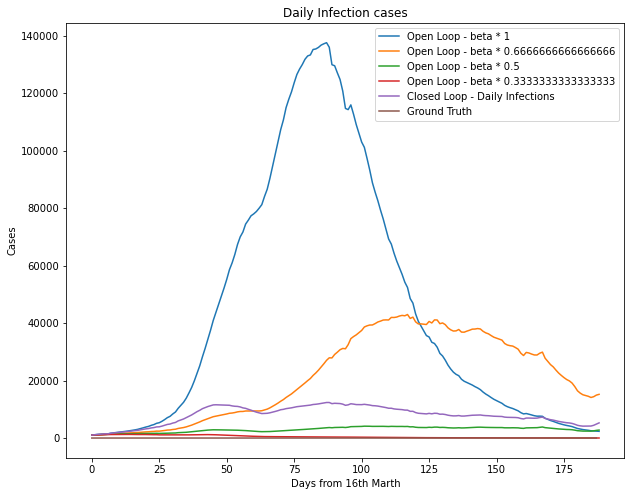

In [82]:
# Question 3 (a)

# Predictions from 27th Apr'21 till 31st Dec'21
ndays = (pd.to_datetime("2021-09-20")-pd.to_datetime("2021-03-16")).days+1
Duration_Part1 = (pd.to_datetime("2021-09-11")-pd.to_datetime("2021-03-16")).days+1

plt.figure(figsize = (10, 8))

#Processing Tests - Keeping Avg number of tests done on 19th Sept as the Avg tests from 20th Sept to 31st Dec
avgTests_16Mar_19Sept = np.array(df_preprocessed[df_preprocessed["Date"]>="2021-03-16"]["Avg_7_Tested"])
lenTestDays = len(avgTests_16Mar_19Sept)
avgTests_19Sept_31Dec = np.ones(ndays-lenTestDays)*avgTests_16Mar_19Sept[lenTestDays-1]
avgTests = np.array(list(avgTests_16Mar_19Sept)+list(avgTests_19Sept_31Dec)) #Mergind both the lists; one contains avg tests till 19th Sept'21; other contains avg tests from 20th Sept'21 till 31st Dec'21

BETA,S0,E0,I0,R0,CIR0=parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5] #These valeus we have opbtained from question 2

#Plotting
flag=3 #To indicate question 3a

#Vaccinations
V=np.array(df_reported["Avg_7_Vaccination"])
list_vacc=np.ones((365))*200000
V=list(V)+list(list_vacc)
V=np.array(V)



# Different CASES with Beta - Plot of Daily Cases
factors=[1,2/3,1/2,1/3]
for factor in factors:
    # Generated per day cases
    genS, genE, genI, genR = generateTimeSeries(S0, E0, I0, R0, N, V, ALPHA, BETA*factor, GAMMA, EPS, ndays, avgTests)
    # Generate CIR values
    genCIR = np.zeros((ndays))
    genCIR[0]=CIR0
    for day in range(1,ndays):
        genCIR[day]=CIR0*(avgTests[0]/avgTests[day])
    dailyCases = np.array(ALPHA*genE.T/genCIR)
    plt.plot(dailyCases, label='Open Loop - beta * ' + str(factor))
    plt.legend()


# Question 3 (b)
ndays = (pd.to_datetime("2021-09-20")-pd.to_datetime("2021-03-16")).days+1

genS, genE, genI, genR = Question_3b_TimeSeries(S0, E0, I0, R0, N, V, ALPHA, BETA, GAMMA, EPS, ndays, avgTests)
genCIR = np.zeros((ndays))
genCIR[0]=CIR0
for day in range(1,ndays):
    genCIR[day]=CIR0*(avgTests[0]/avgTests[day])
dailyCases = np.array(ALPHA*genE.T/genCIR)
plt.plot(dailyCases, label="Closed Loop - Daily Infections")
plt.legend()

#Adding Ground Truth
df_reported=df_preprocessed[(df_preprocessed["Date"]<="2021-09-20") & (df_preprocessed["Date"]>="2021-03-16")].copy().reset_index()
GT=np.log(df_reported["Avg_7_Confirmed"].to_numpy()+1) 
plt.plot(GT, label="Ground Truth")
plt.legend()

plt.title("Daily Infection cases")
plt.xlabel("Days from 16th Marth")
plt.ylabel("Cases")
plt.show()
    


# Combining Open Loop and Closed Loop - Daily Susceptible Cases

<Figure size 432x288 with 0 Axes>

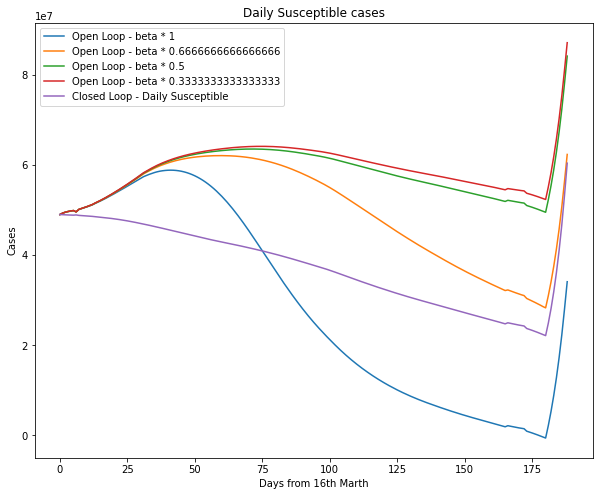

In [81]:
#Open Loop ------------------------------------------------------------------------------------------------------------------------------

# Question 3 (a)

# Predictions from 27th Apr'21 till 31st Dec'21
ndays = (pd.to_datetime("2021-09-20")-pd.to_datetime("2021-03-16")).days+1
Duration_Part1 = (pd.to_datetime("2021-09-11")-pd.to_datetime("2021-03-16")).days+1


#Processing Tests - Keeping Avg number of tests done on 19th Sept as the Avg tests from 20th Sept to 31st Dec
avgTests_16Mar_19Sept = np.array(df_preprocessed[df_preprocessed["Date"]>="2021-03-16"]["Avg_7_Tested"])
lenTestDays = len(avgTests_16Mar_19Sept)
avgTests_19Sept_31Dec = np.ones(ndays-lenTestDays)*avgTests_16Mar_19Sept[lenTestDays-1]
avgTests = np.array(list(avgTests_16Mar_19Sept)+list(avgTests_19Sept_31Dec)) #Mergind both the lists; one contains avg tests till 19th Sept'21; other contains avg tests from 20th Sept'21 till 31st Dec'21

BETA,S0,E0,I0,R0,CIR0=parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5] #These valeus we have opbtained from question 2

#Plotting
flag=3 #To indicate question 3a

#Vaccinations
V=np.array(df_reported["Avg_7_Vaccination"])
list_vacc=np.ones((365))*200000
V=list(V)+list(list_vacc)
V=np.array(V)


plt.clf()
plt.figure(figsize = (10, 8))

# Different CASES with Beta - Plot of Daily Susceptible Cases
factors=[1,2/3,1/2,1/3]
for factor in factors:
    # Generated per day cases
    genS, genE, genI, genR  = generateTimeSeries(S0, E0, I0, R0, N, V, ALPHA, BETA*factor, GAMMA, EPS, ndays, avgTests)
    plt.plot(genS, label='Open Loop - beta * ' + str(factor))
    plt.legend()



# Closed Loop------------------------------------------------------------------------------------------------------------------------------
ndays = (pd.to_datetime("2021-09-20")-pd.to_datetime("2021-03-16")).days+1

genS, genE, genI, genR = Question_3b_TimeSeries(S0, E0, I0, R0, N, V, ALPHA, BETA, GAMMA, EPS, ndays, avgTests)
genCIR = np.zeros((ndays))
genCIR[0]=CIR0
plt.plot(genS, label="Closed Loop - Daily Susceptible")
plt.legend()
    
plt.title("Daily Susceptible cases")
plt.xlabel("Days from 16th Marth")
plt.ylabel("Cases")
plt.show()
    


# Results

In [45]:
# Question 2 Parameters Obtained
#  [0.5662003952194509, 48999999.81495608, 69999.8149267115, 76999.81493622866, 20852999.814954847, 16.7944087505339]
# Question 2 Loss Obtained
#  0.038996716181531096

# Question 2 Parameters Obtained
#  [0.5583076070950681, 48999999.813326664, 76999.8132933375, 76999.81352671931, 20852999.813325353, 16.785445783974108]
# Question 2 Loss Obtained
#  0.027696339575505362


# parameters=Question 2 Parameters Obtained
#  [0.6393190285332008, 48999999.91763111, 76999.91761009558, 76999.91784382031, 20852999.917630345, 16.901465116973373]
# Question 2 Loss Obtained
#  0.009988510218470786


# BETA=0.5253248445115243
# S0=48999999.97139864
# E0=76999.97158373927
# I0=76999.97178136547
# R0=20852999.953767885
# CIR0=14.96806491760319
# loss =  0.014016666870017194


# Question 2 Parameters Obtained
#  [0.5256774699944033, 48999999.971400544, 76999.9715946244, 76999.97179014275, 20852999.953769837, 14.975438010270782]
# Question 2 Loss Obtained
#  0.014030936099635547

# Question 2 Parameters Obtained
#  [0.4827309552922936, 48999999.974591546, 76999.92119648869, 76999.92139724134, 20852999.903192878, 12.879674596064628]
# Question 2 Loss Obtained
#  0.009982751303090717